In [4]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import time
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [5]:
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold, StratifiedShuffleSplit, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.feature_selection import SelectFromModel, VarianceThreshold, SelectKBest, f_classif, chi2
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.pipeline import Pipeline
from scipy import stats
from sklearn.externals import joblib

### Загрузка данных

In [7]:
mri_data = pd.read_csv("data/T1 morphometry merged 27.02.2018.csv", index_col=0)
mri_mprage_data = pd.read_csv("data/MPRAGE morphometry merged 27.02.2018.csv", index_col=0)
mprage_idx = mri_mprage_data['index_r']
#mri_mprage_data = mri_mprage_data.drop(['index_r'], axis = 1)
fmri_data = pd.read_csv("data/T1 functional connectivity 27.02.2018.csv", index_col=0)

labels = pd.read_csv("data/targets 27.02.2018.csv", sep=";")

idx_to_label = ["C", "D", "E", "DE", "NE", "ND", "TLE", "Positive", "Negative", "TLEPositive"]
label_to_idx = {l : i for i, l in enumerate(idx_to_label)}

for col in labels.columns[1:]:
    labels[col] = labels[col].apply(lambda x: label_to_idx[x] if x in label_to_idx else np.nan)
    
EC_idx = labels["E/C"].notnull()
TLE_idx = labels["TLE/no E"].notnull()
TLEC_idx = labels["TLE/C"].notnull()
DC_idx = labels["D/C"].notnull()
DEE_idx = labels["DE/E"].notnull()
#PN_idx = labels["MRIPositive/Negative "].notnull()
#TLEPC_idx = labels["TLEPositive/C"].notnull()



In [26]:
mri_mprage_data.head()

,index_r,bankssts_NumVert_r,caudalanteriorcingulate_NumVert_r,caudalmiddlefrontal_NumVert_r,cuneus_NumVert_r,entorhinal_NumVert_r,fusiform_NumVert_r,inferiorparietal_NumVert_r,inferiortemporal_NumVert_r,isthmuscingulate_NumVert_r,...,Right-VentralDC_normRange,Right-vessel_normRange,Right-choroid-plexus_normRange,5th-Ventricle_normRange,WM-hypointensities_normRange,Optic-Chiasm_normRange,CC_Posterior_normRange,CC_Mid_Posterior_normRange,CC_Central_normRange,CC_Mid_Anterior_normRange
0,P001,1050,1335,2936,2748,560,4286,8259,4150,1484,...,73.0,15.0,53.0,0.0,77.0,63.0,69.0,77.0,85.0,81.0
1,P002,1360,1855,3952,2422,535,5685,8720,5068,2007,...,81.0,0.0,49.0,0.0,79.0,62.0,74.0,95.0,94.0,96.0
2,P003,1180,1207,4667,2679,563,4749,7880,4350,1984,...,78.0,20.0,86.0,0.0,89.0,63.0,98.0,73.0,80.0,93.0
3,P004,1354,1061,2765,2754,549,4079,7476,4006,1418,...,85.0,0.0,62.0,0.0,78.0,82.0,82.0,65.0,84.0,112.0
4,P006,964,1029,3161,2636,586,4298,7384,3941,1394,...,70.0,39.0,52.0,0.0,65.0,69.0,59.0,49.0,76.0,64.0


In [27]:
labels.head()

,patient_number,target,E/no E,D/no D,E/C,TLE/no E,TLE/C,D/C,DE/E,MRIPositive/Negative,TLEPositive/C
0,P001,2,2,5,2.0,6.0,6.0,NaN,2.0,8.0,NaN
1,P002,3,2,1,NaN,NaN,NaN,NaN,3.0,8.0,NaN
2,P003,2,2,5,2.0,6.0,6.0,NaN,2.0,7.0,9.0
3,P004,1,4,1,NaN,4.0,NaN,1.0,NaN,8.0,NaN
4,P006,2,2,5,2.0,NaN,NaN,NaN,2.0,8.0,NaN


In [8]:
# отбор признаков на основе модели
# аналогично SelectFromModel, но на основе количества признаков, а не порога

from sklearn.base import BaseEstimator, MetaEstimatorMixin, clone
from sklearn.feature_selection.base import SelectorMixin
from sklearn.feature_selection.from_model import _get_feature_importances
from sklearn.utils.metaestimators import if_delegate_has_method

class SelectNFeaturesFromModel(BaseEstimator, SelectorMixin, MetaEstimatorMixin):
    def __init__(self, estimator, n_selected, prefit=False):
        self.estimator = estimator
        self.n_selected = n_selected
        self.prefit = prefit

    def _get_support_mask(self):
        if self.prefit:
            estimator = self.estimator
        elif hasattr(self, 'estimator_'):
            estimator = self.estimator_
        else:
            raise ValueError(
                'Either fit SelectFromModel before transform or set "prefit='
                'True" and pass a fitted estimator to the constructor.')
        scores = _get_feature_importances(estimator)
        threshold = np.sort(scores)[-self.n_selected]
        return scores >= threshold

    def fit(self, X, y=None, **fit_params):
        if self.prefit:
            raise NotFittedError(
                "Since 'prefit=True', call transform directly")
        self.estimator_ = clone(self.estimator)
        self.estimator_.fit(X, y, **fit_params)
        return self

    @property
    def threshold_(self):
        scores = _get_feature_importances(self.estimator_, self.norm_order)
        return np.sort(scores)[-n_selected]
    
    @if_delegate_has_method('estimator')
    def partial_fit(self, X, y=None, **fit_params):
        if self.prefit:
            raise NotFittedError(
                "Since 'prefit=True', call transform directly")
        if not hasattr(self, "estimator_"):
            self.estimator_ = clone(self.estimator)
        self.estimator_.partial_fit(X, y, **fit_params)
        return self

In [9]:
def get_svc_grid(cv, dim_reduction_methods, random_state=None,
                 svc_kernel_l=None, svc_c_l=None, svc_gamma_l=None):

    pipe = Pipeline([
        ("Fill_NaN", Imputer(strategy="median")),
        ('StdScaler', StandardScaler()),
        ("VarTh", VarianceThreshold()),
        ('dim_reduction', SelectKBest(stats.ttest_ind)),
        ('classifier', SVC(random_state=random_state)),
    ])

    param_grid = {
        'dim_reduction': dim_reduction_methods,
    }
    if svc_kernel_l is not None:
        param_grid['classifier__kernel'] = svc_kernel_l
    if svc_c_l is not None:
        param_grid['classifier__C'] = svc_c_l
    if svc_gamma_l is not None:
        param_grid['classifier__gamma'] = svc_gamma_l
    
    return GridSearchCV(estimator=pipe, param_grid=param_grid, scoring="accuracy", cv=cv)

In [10]:
def get_lr_grid(cv, dim_reduction_methods, random_state=None,
                 lr_c_l=None):
    
    pipe = Pipeline([
        ("Fill_NaN", Imputer(strategy="median")),
        ('StdScaler', StandardScaler()),
        ("VarTh", VarianceThreshold()),
        ('dim_reduction', SelectKBest(stats.ttest_ind)),
        ('classifier', LogisticRegression(random_state=random_state)),
    ])

    param_grid = {
        'dim_reduction': dim_reduction_methods,
    }
    if lr_c_l is not None:
        param_grid['classifier__C'] = lr_c_l
    
    return GridSearchCV(estimator=pipe, param_grid=param_grid, scoring="accuracy", cv=cv)

In [11]:
def get_rfc_grid(cv, dim_reduction_methods, random_state=None,
                 rfc_n_estimators_l=None):
    
    pipe = Pipeline([
        ("Fill_NaN", Imputer(strategy="median")),
        ('StdScaler', StandardScaler()),
        ("VarTh", VarianceThreshold()),
        ('dim_reduction', SelectKBest(stats.ttest_ind)),
        ('classifier', RandomForestClassifier(random_state=random_state)),
    ])

    param_grid = {
        'dim_reduction': dim_reduction_methods,
    }
    if rfc_n_estimators_l is not None:
        param_grid['classifier__n_estimators'] = rfc_n_estimators_l
    
    return GridSearchCV(estimator=pipe, param_grid=param_grid, scoring="accuracy", cv=cv)

In [12]:
def get_knn_grid(cv, dim_reduction_methods, random_state=None,
                 knn_n_neighbors_l=None, knn_weights_l=None, knn_p_l=None):
    
    pipe = Pipeline([
        ("Fill_NaN", Imputer(strategy="median")),
        ('StdScaler', StandardScaler()),
        ("VarTh", VarianceThreshold()),
        ('dim_reduction', SelectKBest(stats.ttest_ind)),
        ('classifier', KNeighborsClassifier()),
    ])

    param_grid = {
        'dim_reduction': dim_reduction_methods,
    }
    if knn_n_neighbors_l is not None:
        param_grid['classifier__n_neighbors'] = knn_n_neighbors_l
    if knn_weights_l is not None:
        param_grid['classifier__weights'] = knn_weights_l
    if knn_p_l is not None:
        param_grid['classifier__p'] = knn_p_l
    
    return GridSearchCV(estimator=pipe, param_grid=param_grid, scoring="accuracy", cv=cv)

In [13]:
# set printoptions
pd.set_option('expand_frame_repr', True)
pd.set_option('max_colwidth', 150)

In [14]:
def print_results(clf_grid_dict):
    results = {
            "classifier" : [], 
            "best parameters" : [],
            "best dim. reduction method" : [],
            "mean" : [],
            "std" : []
           }
    
    for clf, grid in clf_grid_dict.items():
        results["classifier"].append(clf)
        results["best parameters"].append(", ".join(
            [param + " = " + str(best_value) for param, best_value in grid.best_params_.items() if param != 'dim_reduction']))
        results["best dim. reduction method"].append(grid.best_params_['dim_reduction'])
        idx = grid.best_index_
        results["mean"].append(grid.cv_results_['mean_test_score'][idx])
        results["std"].append(grid.cv_results_['std_test_score'][idx])
        
    results = pd.DataFrame(results, columns=["classifier", "best parameters", "best dim. reduction method", "mean", "std"])
    display(results.set_index("classifier"))
    
    # draw graph
    width = 0.9
    for i in results.index:
        plt.bar(i, results.loc[i, "mean"], width, yerr=results.loc[i, "std"], label=results.loc[i, "classifier"])
    plt.xticks(range(results.shape[0]), results.loc[:, "classifier"])
    plt.axis(ymin=0.0, ymax=1.0)
    plt.show()
    
    print("Best model: ")
    clf = results.loc[results["mean"].argmax(), "classifier"]
    print(clf)
    print("\n".join(
            [param + " = " + str(best_value) for param, best_value in clf_grid_dict[clf].best_params_.items()]))
    print()
    print("mean =", results["mean"].max())
    print("std =", results.loc[results["mean"].argmax(), "std"])

### Объединенный подсчет и сравнение всех классификаторов (SVC, LR, RFC, KNN)

In [15]:
def train_grid_cv(X, y, n_splits, n_repeats, random_state=None):
    cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state)
    
    n_features = [5, 10, 20, 50, 100]
    n_components = [2, 3, 5, 10, 15, 20]
    
    # list of dimensionality reduction methods
    dim_reduction_methods = []
    dim_reduction_methods += [SelectKBest(stats.ttest_ind, n) for n in n_features]
    dim_reduction_methods += [SelectKBest(f_classif, n) for n in n_features]
    dim_reduction_methods += [SelectNFeaturesFromModel(RandomForestClassifier(n_estimators=100, random_state=random_state), n) for n in n_features]
    dim_reduction_methods += [SelectNFeaturesFromModel(LogisticRegression(), n) for n in n_features]
    dim_reduction_methods += [SelectNFeaturesFromModel(ExtraTreesClassifier(n_estimators=100, random_state=random_state), n) for n in n_features]
    dim_reduction_methods += [PCA(n) for n in n_components]
    dim_reduction_methods += [LocallyLinearEmbedding(n_components=n, random_state=random_state) for n in n_components]
    
    
    print("Training SVC...")
    grid_cv_svc = get_svc_grid(cv, dim_reduction_methods, random_state=random_state,
                               svc_kernel_l=["rbf", "linear"],
                               svc_c_l=[10 ** i for i in range(-6, 4, 2)],
                               svc_gamma_l=[10 ** i for i in range(-6, 2, 2)])
    start_time = time.time()
    grid_cv_svc.fit(X, y)
    print("(training took {}s)\n".format(time.time() - start_time))
    
    print("Training LR...")
    grid_cv_lr = get_lr_grid(cv, dim_reduction_methods, random_state=random_state,
                             lr_c_l=[10 ** i for i in range(-6, 2, 2)])
    start_time = time.time()
    grid_cv_lr.fit(X, y)
    print("(training took {}s)\n".format(time.time() - start_time))
    
    print("Training RFC...")
    grid_cv_rfc = get_rfc_grid(cv, dim_reduction_methods, random_state=random_state,
                               rfc_n_estimators_l=[i for i in range(300, 950, 150)])
    start_time = time.time()
    grid_cv_rfc.fit(X, y)
    print("(training took {}s)\n".format(time.time() - start_time))
    
    print("Training KNN...")
    class_size_tr = y.size // len(set(y)) - 5
    grid_cv_knn = get_knn_grid(cv, dim_reduction_methods, random_state=random_state,
                              knn_p_l=[1, 2],
                              knn_weights_l=["uniform", "distance"],
                              knn_n_neighbors_l=[i for i in range(5, class_size_tr - 1, 2)])
    start_time = time.time()
    grid_cv_knn.fit(X, y)
    print("(training took {}s)\n".format(time.time() - start_time))
    
    print_results({
        "SVC" : grid_cv_svc,
        "LR" : grid_cv_lr,
        "RFC" : grid_cv_rfc,
        "KNN" : grid_cv_knn
                  })
    
    best_model = max([grid_cv_svc, grid_cv_lr, grid_cv_rfc, grid_cv_knn], key=lambda x: x.best_score_).best_estimator_
    
    return best_model, grid_cv_svc, grid_cv_lr, grid_cv_rfc, grid_cv_knn

In [16]:
n_objects = mri_data.shape[0]

def repeated_cross_val_predict(estimator, X, y, cv, file=None):
    predictions = [[] for i in range(n_objects)]
    for idx_tr, idx_te in tqdm(cv.split(X, y)):
        estimator.fit(X.iloc[idx_tr], y.iloc[idx_tr])
        pred_te = np.array(estimator.predict(X.iloc[idx_te]), dtype=int)
        for i, idx in enumerate(idx_te):
            predictions[X.index[idx]].append(idx_to_label[pred_te[i]])
        
    predictions = pd.DataFrame(predictions)
    if file is not None:
        predictions.to_csv(file)
        
    return predictions

In [17]:
def save_model(model, file):
    joblib.dump(model, file)
    
def load_model(file):
    model = joblib.load(file)
    return model

### Training

In [27]:
labels.head()

,patient_number,target,E/no E,D/no D,E/C,TLE/no E,TLE/C,D/C,DE/E,MRIPositive/Negative,TLEPositive/C
0,P001,2,2,5,2.0,6.0,6.0,NaN,2.0,8.0,NaN
1,P002,3,2,1,NaN,NaN,NaN,NaN,3.0,8.0,NaN
2,P003,2,2,5,2.0,6.0,6.0,NaN,2.0,7.0,9.0
3,P004,1,4,1,NaN,4.0,NaN,1.0,NaN,8.0,NaN
4,P006,2,2,5,2.0,NaN,NaN,NaN,2.0,8.0,NaN


dataset: MRI T1, MRI MPRAGE, fMRI

EC_idx = labels["E/C"].notnull()
TLE_idx = labels["TLE/no E"].notnull()
TLEC_idx = labels["TLE/C"].notnull()

* Epilepsy / control
* TLE / no epilepsy
* TLE / control

### 4. Epilepsy / control

In [31]:
# fmri_EC = load_model("best_model_fmri_EC.pkl")
# fmri_EC.fit(fmri_data[EC_idx], labels[EC_idx]["E/C"])
# prep = SelectKBest(k=5)
# prep.fit_transform(fmri_data[EC_idx],labels[EC_idx]["E/C"])


Training SVC...
(training took 1795.4724657535553s)

Training LR...
(training took 158.94327998161316s)

Training RFC...
(training took 3093.7265169620514s)

Training KNN...
(training took 1121.0402512550354s)



,best parameters,best dim. reduction method,mean,std
classifier,,,,
SVC,"classifier__C = 1e-06, classifier__gamma = 0.01, classifier__kernel = rbf","SelectNFeaturesFromModel(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',\n max_depth=None, max_fe...",0.684,0.164146
LR,classifier__C = 0.01,"SelectKBest(k=50, score_func=<function ttest_ind at 0x10d2bc8c8>)",0.692,0.123028
RFC,classifier__n_estimators = 750,"SelectKBest(k=20, score_func=<function ttest_ind at 0x10d2bc8c8>)",0.692,0.116344
KNN,"classifier__n_neighbors = 13, classifier__p = 1, classifier__weights = distance","SelectKBest(k=20, score_func=<function ttest_ind at 0x10d2bc8c8>)",0.668,0.125603


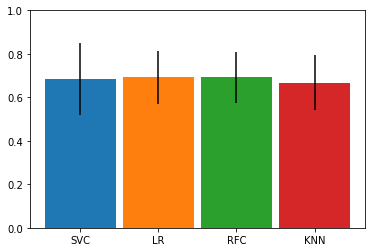

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:37: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
0it [00:00, ?it/s]

Best model: 
LR
classifier__C = 0.01
dim_reduction = SelectKBest(k=50, score_func=<function ttest_ind at 0x10d2bc8c8>)

mean = 0.692
std = 0.123028451994


50it [00:00, 146.29it/s]


Training SVC...
(training took 1857.007907629013s)

Training LR...
(training took 163.06337594985962s)

Training RFC...
(training took 3062.892895936966s)

Training KNN...
(training took 1153.5205371379852s)



,best parameters,best dim. reduction method,mean,std
classifier,,,,
SVC,"classifier__C = 1, classifier__gamma = 0.01, classifier__kernel = rbf","SelectKBest(k=5, score_func=<function f_classif at 0x10d5b6ae8>)",0.644,0.113420
LR,classifier__C = 0.01,"SelectNFeaturesFromModel(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',\n max_depth=None, max_fe...",0.632,0.122376
RFC,classifier__n_estimators = 600,"SelectKBest(k=10, score_func=<function f_classif at 0x10d5b6ae8>)",0.644,0.135882
KNN,"classifier__n_neighbors = 17, classifier__p = 1, classifier__weights = uniform","PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,\n svd_solver='auto', tol=0.0, whiten=False)",0.620,0.174356


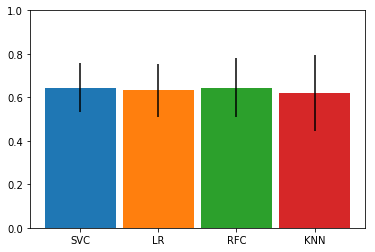

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:37: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
0it [00:00, ?it/s]

Best model: 
SVC
classifier__C = 1
classifier__gamma = 0.01
classifier__kernel = rbf
dim_reduction = SelectKBest(k=5, score_func=<function f_classif at 0x10d5b6ae8>)

mean = 0.644
std = 0.11341957503


50it [00:00, 136.60it/s]


Training SVC...
(training took 1600.8521599769592s)

Training LR...
(training took 152.2985987663269s)

Training RFC...
(training took 3021.199866294861s)

Training KNN...
(training took 928.8633890151978s)



,best parameters,best dim. reduction method,mean,std
classifier,,,,
SVC,"classifier__C = 0.01, classifier__gamma = 1e-06, classifier__kernel = linear","SelectNFeaturesFromModel(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',\n max_depth=None, max_fe...",0.727273,0.110958
LR,classifier__C = 1,"SelectKBest(k=100, score_func=<function ttest_ind at 0x10d2bc8c8>)",0.727273,0.111129
RFC,classifier__n_estimators = 600,"SelectNFeaturesFromModel(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, ma...",0.722727,0.144473
KNN,"classifier__n_neighbors = 13, classifier__p = 2, classifier__weights = distance","SelectKBest(k=20, score_func=<function f_classif at 0x10d5b6ae8>)",0.704545,0.148195


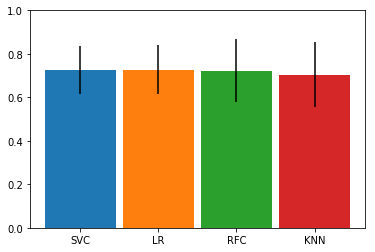

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:37: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
0it [00:00, ?it/s]

Best model: 
SVC
classifier__C = 0.01
classifier__gamma = 1e-06
classifier__kernel = linear
dim_reduction = SelectNFeaturesFromModel(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
             n_selected=100, prefit=False)

mean = 0.727272727273
std = 0.110958343096


50it [00:06,  8.07it/s]


In [84]:
n_splits = 5
cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=10, random_state=42)
## MRI
X, y = mri_data[EC_idx], labels[EC_idx]["E/C"]

best_model_mri_EC = train_grid_cv(X, y, n_splits=n_splits, n_repeats=5)[0]


labels_mri_EC = repeated_cross_val_predict(best_model_mri_EC, X, y, cv, file="labels_mri_EC.csv")

save_model(best_model_mri_EC, "best_model_mri_EC.pkl")

## fMRI
X, y = fmri_data[EC_idx], labels[EC_idx]["E/C"]

best_model_fmri_EC = train_grid_cv(X, y, n_splits=n_splits, n_repeats=5)[0]


labels_fmri_EC = repeated_cross_val_predict(best_model_fmri_EC, X, y, cv, file="labels_fmri_EC.csv")

save_model(best_model_fmri_EC, "best_model_fmri_EC.pkl")


## MRI MPRAGE
X = mri_mprage_data[mri_mprage_data['index_r'].isin(labels[EC_idx]['patient_number'])].drop(['index_r'], axis = 1)
y = labels[labels['patient_number'].isin(mprage_idx) & EC_idx]["E/C"]

best_model_mri_mprage_EC = train_grid_cv(X, y, n_splits=n_splits, n_repeats=5)[0]


labels_mri_mprage_EC = repeated_cross_val_predict(best_model_mri_mprage_EC, X, y, cv, file="labels_mri_mprage_EC.csv")

save_model(best_model_mri_mprage_EC, "best_model_mri_mprage_EC.pkl")

In [39]:
dim_reduction = SelectNFeaturesFromModel(estimator=LogisticRegression(), n_selected=20)

X = mri_mprage_data[mri_mprage_data['index_r'].isin(labels[DC_idx]['patient_number'])].drop(['index_r'], axis = 1)
y = labels[labels['patient_number'].isin(mprage_idx) & DC_idx]["D/C"]

idx = dim_reduction.fit(X, y).get_support(indices = True)
mri_mprage_data.iloc[:,idx].columns

Index(['cuneus_GrayVol_r', 'lateralorbitofrontal_GrayVol_r',
       'posteriorcingulate_GrayVol_r', 'rostralanteriorcingulate_GrayVol_r',
       'superiorfrontal_GrayVol_r', 'frontalpole_GrayVol_r',
       'transversetemporal_GrayVol_r', 'pericalcarine_NumVert_l',
       'fusiform_GrayVol_l', 'inferiorparietal_GrayVol_l',
       'pericalcarine_GrayVol_l', 'rostralmiddlefrontal_GrayVol_l',
       'superiorfrontal_GrayVol_l', 'superiorparietal_GrayVol_l',
       'superiortemporal_GrayVol_l', 'transversetemporal_GrayVol_l',
       '4th-Ventricle_NVoxels', 'Right-Thalamus-Proper_NVoxels',
       '4th-Ventricle_Volume_mm3', 'Right-Thalamus-Proper_Volume_mm3'],
      dtype='object')

### 5. Depression / control

Training SVC...
(training took 1618.191285610199s)

Training LR...
(training took 137.2857096195221s)

Training RFC...
(training took 2590.2925939559937s)

Training KNN...
(training took 977.52973985672s)



,best parameters,best dim. reduction method,mean,std
classifier,,,,
SVC,"classifier__C = 100, classifier__gamma = 1, classifier__kernel = linear","SelectNFeaturesFromModel(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',\n max_depth=None, max_fe...",0.648,0.149987
LR,classifier__C = 1,"LocallyLinearEmbedding(eigen_solver='auto', hessian_tol=0.0001, max_iter=100,\n method='standard', modified_tol=1e-12, n_components=3,\...",0.640,0.138564
RFC,classifier__n_estimators = 600,"SelectNFeaturesFromModel(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',\n max_depth=None, max_fe...",0.712,0.121062
KNN,"classifier__n_neighbors = 5, classifier__p = 1, classifier__weights = distance","SelectNFeaturesFromModel(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',\n max_depth=None, max_fe...",0.700,0.129615


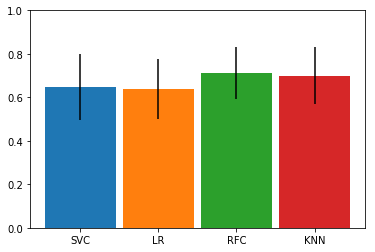

Best model: 
RFC
classifier__n_estimators = 600
dim_reduction = SelectNFeaturesFromModel(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
             n_selected=10, prefit=False)

mean = 0.712
std = 0.121061967603


50it [00:29,  1.69it/s]


Training SVC...
(training took 1643.918541431427s)

Training LR...
(training took 142.16318273544312s)

Training RFC...
(training took 2598.188595533371s)

Training KNN...
(training took 1013.493335723877s)



,best parameters,best dim. reduction method,mean,std
classifier,,,,
SVC,"classifier__C = 100, classifier__gamma = 0.01, classifier__kernel = rbf","PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,\n svd_solver='auto', tol=0.0, whiten=False)",0.584,0.122246
LR,classifier__C = 0.01,"SelectNFeaturesFromModel(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, ma...",0.564,0.138217
RFC,classifier__n_estimators = 300,"PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,\n svd_solver='auto', tol=0.0, whiten=False)",0.564,0.141082
KNN,"classifier__n_neighbors = 5, classifier__p = 2, classifier__weights = distance","PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,\n svd_solver='auto', tol=0.0, whiten=False)",0.620,0.141421


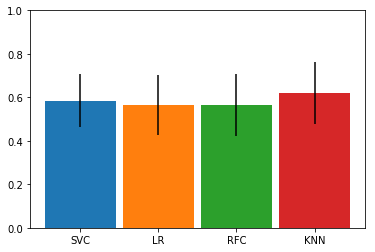

Best model: 
KNN
classifier__n_neighbors = 5
classifier__p = 2
classifier__weights = distance
dim_reduction = PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

mean = 0.62
std = 0.141421356237


50it [00:00, 111.78it/s]


Training SVC...
(training took 1479.9325048923492s)

Training LR...
(training took 134.86198234558105s)

Training RFC...
(training took 2566.16242146492s)

Training KNN...
(training took 820.5256109237671s)



,best parameters,best dim. reduction method,mean,std
classifier,,,,
SVC,"classifier__C = 1, classifier__gamma = 1e-06, classifier__kernel = linear","SelectNFeaturesFromModel(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, ma...",0.655319,0.159050
LR,classifier__C = 0.01,"SelectNFeaturesFromModel(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, ma...",0.638298,0.133462
RFC,classifier__n_estimators = 450,"SelectKBest(k=100, score_func=<function ttest_ind at 0x000001A1F718A6A8>)",0.608511,0.135395
KNN,"classifier__n_neighbors = 15, classifier__p = 1, classifier__weights = uniform","SelectNFeaturesFromModel(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, ma...",0.642553,0.124286


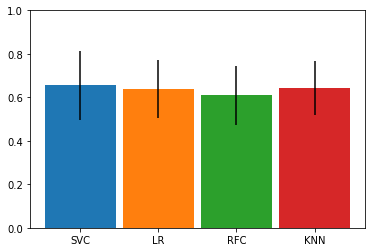

Best model: 
SVC
classifier__C = 1
classifier__gamma = 1e-06
classifier__kernel = linear
dim_reduction = SelectNFeaturesFromModel(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
             n_selected=20, prefit=False)

mean = 0.655319148936
std = 0.159049570123


50it [00:00, 117.01it/s]


In [41]:
n_splits = 5
cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=10, random_state=42)

## MRI

X, y = mri_data[DC_idx], labels[DC_idx]["D/C"]

best_model_mri_DC = train_grid_cv(X, y, n_splits=n_splits, n_repeats=5)[0]

labels_mri_DC = repeated_cross_val_predict(best_model_mri_DC, X, y, cv, file="labels_mri_DC.csv")

save_model(best_model_mri_DC, "best_model_mri_DC.pkl")

## fMRI
X, y = fmri_data[DC_idx], labels[DC_idx]["D/C"]

best_model_fmri_DC = train_grid_cv(X, y, n_splits=n_splits, n_repeats=5)[0]

labels_fmri_DC = repeated_cross_val_predict(best_model_fmri_DC, X, y, cv, file="labels_fmri_DC.csv")

save_model(best_model_fmri_DC, "best_model_fmri_DC.pkl")


## MRI MPRAGE
X = mri_mprage_data[mri_mprage_data['index_r'].isin(labels[DC_idx]['patient_number'])].drop(['index_r'], axis = 1)
y = labels[labels['patient_number'].isin(mprage_idx) & DC_idx]["D/C"]

best_model_mri_mprage_DC = train_grid_cv(X, y, n_splits=n_splits, n_repeats=5)[0]

labels_mri_mprage_DC = repeated_cross_val_predict(best_model_mri_mprage_DC, X, y, cv, file="labels_mri_mprage_DC.csv")

save_model(best_model_mri_mprage_DC, "best_model_mri_mprage_DC.pkl")

### 6. Epilepsy with depression / only epilepsy

Training SVC...
(training took 1570.3997151851654s)

Training LR...
(training took 136.92345237731934s)

Training RFC...
(training took 2574.9677345752716s)

Training KNN...
(training took 969.9943768978119s)



,best parameters,best dim. reduction method,mean,std
classifier,,,,
SVC,"classifier__C = 1, classifier__gamma = 0.01, classifier__kernel = rbf","SelectKBest(k=50, score_func=<function ttest_ind at 0x000001A1F718A6A8>)",0.588,0.142324
LR,classifier__C = 1,"SelectKBest(k=10, score_func=<function ttest_ind at 0x000001A1F718A6A8>)",0.548,0.162776
RFC,classifier__n_estimators = 600,"SelectKBest(k=50, score_func=<function ttest_ind at 0x000001A1F718A6A8>)",0.568,0.180488
KNN,"classifier__n_neighbors = 5, classifier__p = 1, classifier__weights = distance","PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,\n svd_solver='auto', tol=0.0, whiten=False)",0.644,0.126744


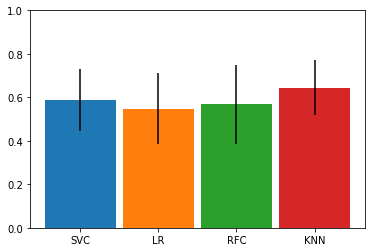

Best model: 
KNN
classifier__n_neighbors = 5
classifier__p = 1
classifier__weights = distance
dim_reduction = PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

mean = 0.644
std = 0.126743836142


50it [00:00, 126.49it/s]


Training SVC...
(training took 1651.2092199325562s)

Training LR...
(training took 141.9550335407257s)

Training RFC...
(training took 2577.715653896332s)

Training KNN...
(training took 1005.8508965969086s)



,best parameters,best dim. reduction method,mean,std
classifier,,,,
SVC,"classifier__C = 100, classifier__gamma = 1e-06, classifier__kernel = linear","LocallyLinearEmbedding(eigen_solver='auto', hessian_tol=0.0001, max_iter=100,\n method='standard', modified_tol=1e-12, n_components=2,\...",0.616,0.154091
LR,classifier__C = 1e-06,"LocallyLinearEmbedding(eigen_solver='auto', hessian_tol=0.0001, max_iter=100,\n method='standard', modified_tol=1e-12, n_components=3,\...",0.592,0.116344
RFC,classifier__n_estimators = 750,"PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,\n svd_solver='auto', tol=0.0, whiten=False)",0.568,0.131818
KNN,"classifier__n_neighbors = 13, classifier__p = 1, classifier__weights = uniform","LocallyLinearEmbedding(eigen_solver='auto', hessian_tol=0.0001, max_iter=100,\n method='standard', modified_tol=1e-12, n_components=2,\...",0.628,0.134224


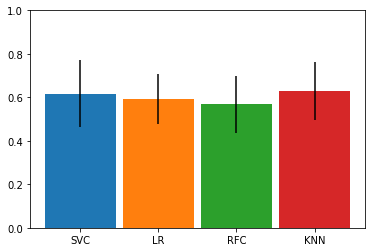

Best model: 
KNN
classifier__n_neighbors = 13
classifier__p = 1
classifier__weights = uniform
dim_reduction = LocallyLinearEmbedding(eigen_solver='auto', hessian_tol=0.0001, max_iter=100,
            method='standard', modified_tol=1e-12, n_components=2,
            n_jobs=1, n_neighbors=5, neighbors_algorithm='auto',
            random_state=None, reg=0.001, tol=1e-06)

mean = 0.628
std = 0.134223693885


50it [00:00, 55.39it/s]


Training SVC...
(training took 1390.1133890151978s)

Training LR...
(training took 131.17046427726746s)

Training RFC...
(training took 2542.5436210632324s)

Training KNN...
(training took 665.0062992572784s)



,best parameters,best dim. reduction method,mean,std
classifier,,,,
SVC,"classifier__C = 1, classifier__gamma = 0.01, classifier__kernel = rbf","PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,\n svd_solver='auto', tol=0.0, whiten=False)",0.632558,0.106200
LR,classifier__C = 1,"LocallyLinearEmbedding(eigen_solver='auto', hessian_tol=0.0001, max_iter=100,\n method='standard', modified_tol=1e-12, n_components=20,...",0.586047,0.121358
RFC,classifier__n_estimators = 750,"PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,\n svd_solver='auto', tol=0.0, whiten=False)",0.553488,0.194251
KNN,"classifier__n_neighbors = 9, classifier__p = 2, classifier__weights = uniform","PCA(copy=True, iterated_power='auto', n_components=20, random_state=None,\n svd_solver='auto', tol=0.0, whiten=False)",0.609302,0.154448


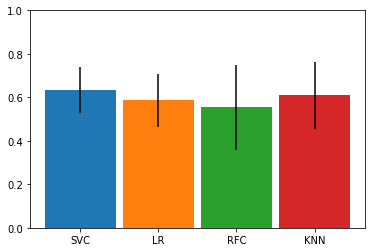

Best model: 
SVC
classifier__C = 1
classifier__gamma = 0.01
classifier__kernel = rbf
dim_reduction = PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

mean = 0.632558139535
std = 0.106200135791


50it [00:00, 141.14it/s]


In [42]:
n_splits = 5
cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=10, random_state=42)

## MRI

X, y = mri_data[DEE_idx], labels[DEE_idx]["DE/E"]

best_model_mri_DEE = train_grid_cv(X, y, n_splits=n_splits, n_repeats=5)[0]

labels_mri_DEE = repeated_cross_val_predict(best_model_mri_DEE, X, y, cv, file="labels_mri_DEE.csv")

save_model(best_model_mri_DEE, "best_model_mri_DEE.pkl")

## fMRI
X, y = fmri_data[DEE_idx], labels[DEE_idx]["DE/E"]

best_model_fmri_DEE = train_grid_cv(X, y, n_splits=n_splits, n_repeats=5)[0]

labels_fmri_DEE = repeated_cross_val_predict(best_model_fmri_DEE, X, y, cv, file="labels_fmri_DEE.csv")

save_model(best_model_fmri_DEE, "best_model_fmri_DEE.pkl")


## MRI MPRAGE
X = mri_mprage_data[mri_mprage_data['index_r'].isin(labels[DEE_idx]['patient_number'])].drop(['index_r'], axis = 1)
y = labels[labels['patient_number'].isin(mprage_idx) & DEE_idx]["DE/E"]

best_model_mri_mprage_DEE = train_grid_cv(X, y, n_splits=n_splits, n_repeats=5)[0]

labels_mri_mprage_DEE = repeated_cross_val_predict(best_model_mri_mprage_DEE, X, y, cv, file="labels_mri_mprage_DEE.csv")

save_model(best_model_mri_mprage_DEE, "best_model_mri_mprage_DEE.pkl")

### 7. TLE / no epilepsy

Training SVC...
(training took 2112.7005109786987s)

Training LR...
(training took 184.22246193885803s)

Training RFC...
(training took 3150.7145631313324s)

Training KNN...
(training took 2824.847409725189s)



,best parameters,best dim. reduction method,mean,std
classifier,,,,
SVC,"classifier__C = 1, classifier__gamma = 1e-06, classifier__kernel = linear","SelectNFeaturesFromModel(estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',\n max_depth=None, max_feat...",0.7650,0.105000
LR,classifier__C = 1,"SelectKBest(k=100, score_func=<function f_classif at 0x10d5b6ae8>)",0.7525,0.111074
RFC,classifier__n_estimators = 450,"SelectNFeaturesFromModel(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, ma...",0.7400,0.070000
KNN,"classifier__n_neighbors = 5, classifier__p = 2, classifier__weights = uniform","SelectNFeaturesFromModel(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, ma...",0.7175,0.079294


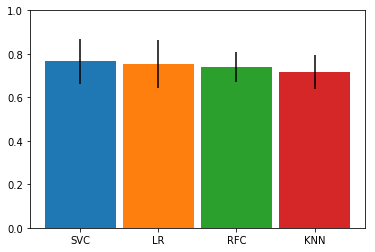

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:37: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
0it [00:00, ?it/s]

Best model: 
SVC
classifier__C = 1
classifier__gamma = 1e-06
classifier__kernel = linear
dim_reduction = SelectNFeaturesFromModel(estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
             n_selected=100, prefit=False)

mean = 0.765
std = 0.105


50it [00:06,  8.09it/s]


Training SVC...
(training took 2787.0083367824554s)

Training LR...
(training took 199.69903683662415s)

Training RFC...
(training took 3204.510521173477s)

Training KNN...
(training took 3017.130604028702s)



,best parameters,best dim. reduction method,mean,std
classifier,,,,
SVC,"classifier__C = 100, classifier__gamma = 0.0001, classifier__kernel = rbf","PCA(copy=True, iterated_power='auto', n_components=20, random_state=None,\n svd_solver='auto', tol=0.0, whiten=False)",0.6600,0.079215
LR,classifier__C = 1,"PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,\n svd_solver='auto', tol=0.0, whiten=False)",0.6400,0.073485
RFC,classifier__n_estimators = 750,"PCA(copy=True, iterated_power='auto', n_components=20, random_state=None,\n svd_solver='auto', tol=0.0, whiten=False)",0.6450,0.078502
KNN,"classifier__n_neighbors = 11, classifier__p = 2, classifier__weights = distance","SelectNFeaturesFromModel(estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',\n max_depth=None, max_feat...",0.6525,0.063934


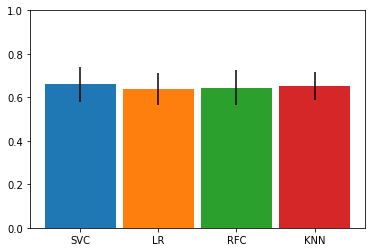

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:37: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
0it [00:00, ?it/s]

Best model: 
SVC
classifier__C = 100
classifier__gamma = 0.0001
classifier__kernel = rbf
dim_reduction = PCA(copy=True, iterated_power='auto', n_components=20, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

mean = 0.66
std = 0.0792148975888


50it [00:00, 74.08it/s]


Training SVC...
(training took 2117.143044948578s)

Training LR...
(training took 175.78347301483154s)

Training RFC...
(training took 3126.9787900447845s)

Training KNN...
(training took 2141.669811964035s)



,best parameters,best dim. reduction method,mean,std
classifier,,,,
SVC,"classifier__C = 100, classifier__gamma = 0.01, classifier__kernel = rbf","SelectNFeaturesFromModel(estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',\n max_depth=None, max_feat...",0.785915,0.114594
LR,classifier__C = 0.01,"SelectNFeaturesFromModel(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, ma...",0.769014,0.105503
RFC,classifier__n_estimators = 450,"SelectNFeaturesFromModel(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, ma...",0.822535,0.100675
KNN,"classifier__n_neighbors = 7, classifier__p = 2, classifier__weights = distance","SelectKBest(k=5, score_func=<function f_classif at 0x10d5b6ae8>)",0.814085,0.077811


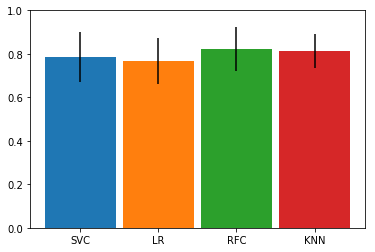

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:37: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
0it [00:00, ?it/s]

Best model: 
RFC
classifier__n_estimators = 450
dim_reduction = SelectNFeaturesFromModel(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
             n_selected=10, prefit=False)

mean = 0.822535211268
std = 0.100675277582


50it [00:23,  2.17it/s]


In [85]:
n_splits = 5 
cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=10, random_state=42)

## MRI
X, y = mri_data[TLE_idx], labels[TLE_idx]["TLE/no E"]

best_model_mri_TLE = train_grid_cv(X, y, n_splits=n_splits, n_repeats=5)[0]

labels_mri_TLE = repeated_cross_val_predict(best_model_mri_TLE, X, y, cv, file="labels_mri_TLE.csv")

save_model(best_model_mri_TLE, "best_model_mri_TLE.pkl")

## fMRI
X, y = fmri_data[TLE_idx], labels[TLE_idx]["TLE/no E"]

best_model_fmri_TLE = train_grid_cv(X, y, n_splits=n_splits, n_repeats=5)[0]

labels_fmri_TLE = repeated_cross_val_predict(best_model_fmri_TLE, X, y, cv, file="labels_fmri_TLE.csv")

save_model(best_model_fmri_TLE, "best_model_fmri_TLE.pkl")


## MRI MPRAGE
X = mri_mprage_data[mri_mprage_data['index_r'].isin(labels[TLE_idx]['patient_number'])].drop(['index_r'], axis = 1)
y = labels[labels['patient_number'].isin(mprage_idx) & TLE_idx]["TLE/no E"]

best_model_mri_mprage_TLE = train_grid_cv(X, y, n_splits=n_splits, n_repeats=5)[0]

labels_mri_mprage_TLE = repeated_cross_val_predict(best_model_mri_mprage_TLE, X, y, cv, file="labels_mri_mprage_TLE.csv")

save_model(best_model_mri_mprage_TLE, "best_model_mri_mprage_TLE.pkl")

In [17]:
labels[TLE_idx]["TLE/no E"].value_counts()

4.0    50
6.0    30
Name: TLE/no E, dtype: int64

### 8. TLE / control

Training SVC...
(training took 1703.5020768642426s)

Training LR...
(training took 161.6047751903534s)

Training RFC...
(training took 3069.0912897586823s)

Training KNN...
(training took 1311.9148080348969s)



,best parameters,best dim. reduction method,mean,std
classifier,,,,
SVC,"classifier__C = 100, classifier__gamma = 0.01, classifier__kernel = rbf","SelectKBest(k=50, score_func=<function f_classif at 0x10d5b6ae8>)",0.730909,0.124595
LR,classifier__C = 0.01,"PCA(copy=True, iterated_power='auto', n_components=20, random_state=None,\n svd_solver='auto', tol=0.0, whiten=False)",0.741818,0.111132
RFC,classifier__n_estimators = 750,"SelectKBest(k=100, score_func=<function ttest_ind at 0x10d2bc8c8>)",0.712727,0.137703
KNN,"classifier__n_neighbors = 7, classifier__p = 1, classifier__weights = uniform","SelectNFeaturesFromModel(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, ma...",0.727273,0.096209


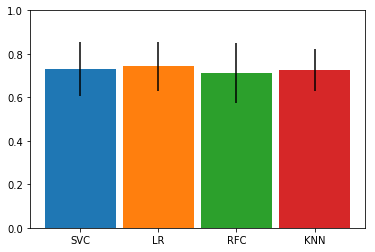

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:37: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
0it [00:00, ?it/s]

Best model: 
LR
classifier__C = 0.01
dim_reduction = PCA(copy=True, iterated_power='auto', n_components=20, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

mean = 0.741818181818
std = 0.111132413018


50it [00:00, 102.33it/s]


Training SVC...
(training took 1940.3738422393799s)

Training LR...
(training took 167.70249485969543s)

Training RFC...
(training took 3083.5347509384155s)

Training KNN...
(training took 1361.05016207695s)



,best parameters,best dim. reduction method,mean,std
classifier,,,,
SVC,"classifier__C = 0.01, classifier__gamma = 1, classifier__kernel = linear","PCA(copy=True, iterated_power='auto', n_components=5, random_state=None,\n svd_solver='auto', tol=0.0, whiten=False)",0.618182,0.143164
LR,classifier__C = 0.01,"SelectKBest(k=100, score_func=<function ttest_ind at 0x10d2bc8c8>)",0.625455,0.136836
RFC,classifier__n_estimators = 450,"PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,\n svd_solver='auto', tol=0.0, whiten=False)",0.585455,0.115222
KNN,"classifier__n_neighbors = 19, classifier__p = 2, classifier__weights = uniform","SelectKBest(k=100, score_func=<function ttest_ind at 0x10d2bc8c8>)",0.621818,0.098518


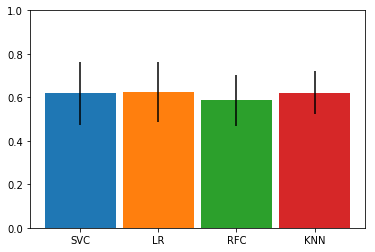

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:37: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
0it [00:00, ?it/s]

Best model: 
LR
classifier__C = 0.01
dim_reduction = SelectKBest(k=100, score_func=<function ttest_ind at 0x10d2bc8c8>)

mean = 0.625454545455
std = 0.136835547071


50it [00:00, 131.02it/s]


Training SVC...
(training took 1626.1974840164185s)

Training LR...
(training took 155.6629729270935s)

Training RFC...
(training took 3044.862685918808s)

Training KNN...
(training took 945.4382221698761s)



,best parameters,best dim. reduction method,mean,std
classifier,,,,
SVC,"classifier__C = 1, classifier__gamma = 0.01, classifier__kernel = rbf","SelectNFeaturesFromModel(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, ma...",0.812766,0.089470
LR,classifier__C = 0.01,"SelectNFeaturesFromModel(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, ma...",0.761702,0.095645
RFC,classifier__n_estimators = 600,"SelectNFeaturesFromModel(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, ma...",0.791489,0.132483
KNN,"classifier__n_neighbors = 5, classifier__p = 1, classifier__weights = distance","SelectNFeaturesFromModel(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, ma...",0.765957,0.107901


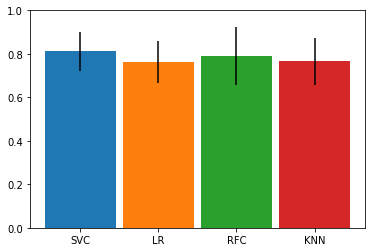

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:37: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
0it [00:00, ?it/s]

Best model: 
SVC
classifier__C = 1
classifier__gamma = 0.01
classifier__kernel = rbf
dim_reduction = SelectNFeaturesFromModel(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
             n_selected=100, prefit=False)

mean = 0.812765957447
std = 0.0894699895509


50it [00:00, 102.64it/s]


In [86]:
n_splits = 5 
cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=10, random_state=42)

## MRI 
X, y = mri_data[TLEC_idx], labels[TLEC_idx]["TLE/C"]

best_model_mri_TLEC = train_grid_cv(X, y, n_splits=n_splits, n_repeats=5)[0]

labels_mri_TLEC = repeated_cross_val_predict(best_model_mri_TLEC, X, y, cv, file="labels_mri_TLEC.csv")

save_model(best_model_mri_TLEC, "best_model_mri_TLEC.pkl")


## fMRI
X, y = fmri_data[TLEC_idx], labels[TLEC_idx]["TLE/C"]

best_model_fmri_TLEC = train_grid_cv(X, y, n_splits=n_splits, n_repeats=5)[0]

labels_fmri_TLEC = repeated_cross_val_predict(best_model_fmri_TLEC, X, y, cv, file="labels_fmri_TLEC.csv")

save_model(best_model_fmri_TLEC, "best_model_fmri_TLEC.pkl")


## MRI MPRAGE
X = mri_mprage_data[mri_mprage_data['index_r'].isin(labels[TLEC_idx]['patient_number'])].drop(['index_r'], axis = 1)
y = labels[labels['patient_number'].isin(mprage_idx) & TLEC_idx]["TLE/C"]

best_model_mri_mprage_TLEC = train_grid_cv(X, y, n_splits=n_splits, n_repeats=5)[0]

labels_mri_mprage_TLEC = repeated_cross_val_predict(best_model_mri_mprage_TLEC, X, y, cv, file="labels_mri_mprage_TLEC.csv")

save_model(best_model_mri_mprage_TLEC, "best_model_mri_mprage_TLEC.pkl")

In [21]:
labels[TLEC_idx]["TLE/C"].value_counts()

6.0    30
0.0    25
Name: TLE/C, dtype: int64